# Ciclo 1: Health Insurance Cross-Sell

# Imports

In [406]:
import pandas as pd
import numpy as np
import pickle
import psycopg2
import pandas.io.sql as psql
import seaborn as sns
import scikitplot as skplt
import requests
import json
import random as rd
import matplotlib
import matplotlib.pyplot      as plt

import sklearn
from sklearn import model_selection as ms
from sklearn import ensemble as en

import sklearn.neighbors as nh
import sklearn.linear_model as lm


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Functions

In [ ]:
def precision_at_k(data, k= 2000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k,'precision_at_k']

def recall_at_k(data, k= 2000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k,'recall_at_k']

def check_performance(results_list, x_validation, y_validation,num):
    list_precision = []
    list_recall = []
    df_precision = pd.DataFrame()
    df_recall = pd.DataFrame()
    n = 0
    for i in results_list:
        #print(i)
        df8 = x_validation.copy()
        df8['response'] = y_validation.copy()
        df8['score'] = i[:,1].tolist()
        df8 = df8[['id','response','score']].sort_values('score', ascending=False)
        
        list_precision.append(precision_at_k(df8,k=num))
        list_recall.append(recall_at_k(df8,k=num))
        
        #print(list_recall)
        
        #df_precision = pd.DataFrame(
        #            {
        #                list_precision
        #            }
        #)
    df_precision = df_precision.append(list_precision)
    df_recall = df_recall.append(list_recall)
    return df_precision, df_recall #list_precision, list_recall

def check_performance1(results_list, x_validation, y_validation,num):
    list_precision = []
    list_recall = []
    df_precision = pd.DataFrame()
    df_recall = pd.DataFrame()
    n = 0
    #for i in results_list:
        #print(i)
    df8 = x_validation.copy()
    df8['response'] = y_validation.copy()
    df8['score'] = results_list[:,1].tolist()
    df8 = df8[['id','response','score']].sort_values('score', ascending=False)

    list_precision.append(precision_at_k(df8,k=num))
    list_recall.append(recall_at_k(df8,k=num))
        
        #print(list_recall)
        
        #df_precision = pd.DataFrame(
        #            {
        #                list_precision
        #            }
        #)
    df_precision = df_precision.append(list_precision)
    df_recall = df_recall.append(list_recall)
    return [df_precision, df_recall] #list_precision, list_recall


# Data Load

In [3]:
conn = psycopg2.connect(
        host="comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com",
        database="comunidadedsdb",
        user="member",
        password="cdspa"

)

cur = conn.cursor()
        
#query = "select * from pa004.users"
#
#cur.execute(query)
#dados = cur.fetchall()
#dados

In [4]:
query = """select users.id, gender, age, driving_license, region_code, previously_insured, vehicle_age, vehicle_damage,
                annual_premium,
                policy_sales_channel,
                vintage,
                response
            from pa004.users
                inner join pa004.insurance i on i.id = users.id
                inner join pa004.vehicle v on v.id = users.id"""

df = psql.read_sql(query, conn)
df.head()

C:\Users\thale\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
2,18,Female,25,1,35.0,1,< 1 Year,No,46622.0,152.0,299,0
3,31,Female,26,1,8.0,0,< 1 Year,No,2630.0,160.0,136,0
4,39,Male,45,1,8.0,0,1-2 Year,Yes,42297.0,124.0,264,0


In [634]:
df_production = pd.read_csv('../data/test.csv')

# 1.0 Descrição dos Dados

In [5]:
df1 = df.copy()

In [6]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
2,18,Female,25,1,35.0,1,< 1 Year,No,46622.0,152.0,299,0
3,31,Female,26,1,8.0,0,< 1 Year,No,2630.0,160.0,136,0
4,39,Male,45,1,8.0,0,1-2 Year,Yes,42297.0,124.0,264,0


## 1.1 Dimensão dos Dados

In [7]:
df1.shape

(381109, 12)

## 1.2 Tipo dos Dados

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check Na

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Alterar Tipo dos Dados

In [10]:
#df1['response'] = df1['response'].astype('str')

## 1.4 Análise Estatística

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [12]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engineering

In [13]:
df2 = df1.copy()

In [14]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
2,18,Female,25,1,35.0,1,< 1 Year,No,46622.0,152.0,299,0
3,31,Female,26,1,8.0,0,< 1 Year,No,2630.0,160.0,136,0
4,39,Male,45,1,8.0,0,1-2 Year,Yes,42297.0,124.0,264,0


In [15]:
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 EDA

In [16]:
df3 = df2.copy()

In [17]:
df3.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 3.1 Análise Univariada

<AxesSubplot:xlabel='response', ylabel='age'>

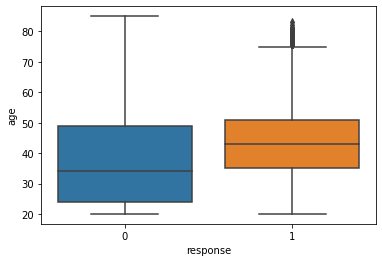

In [18]:
# age
sns.boxplot(x='response', y='age', data=df3)

<AxesSubplot:xlabel='age', ylabel='Count'>

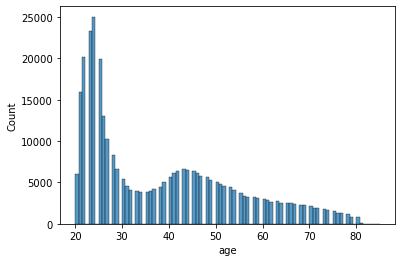

In [19]:
aux00 = df3.loc[df2['response'] == 0, 'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

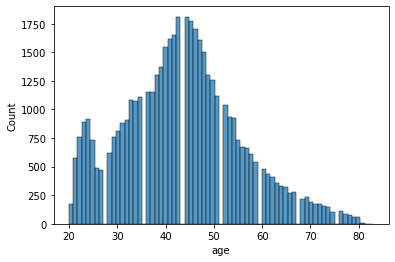

In [20]:
aux01 = df3.loc[df2['response'] == 1, 'age']
sns.histplot(aux01)

In [21]:
# gender

In [22]:
#driving_license
aux = df3[['driving_license','response']].groupby('response').sum().reset_index()
aux['driving_lic_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_lic_perc
0,0,333628,0.877283
1,1,46669,0.122717


<AxesSubplot:xlabel='region_code', ylabel='id'>

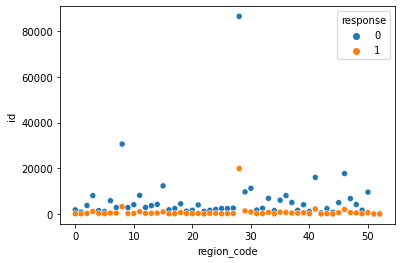

In [23]:
#region_code

aux0 = df3[['id', 'region_code', 'response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x='region_code',y='id',hue='response', data=aux0)


In [24]:
#previously_insured
pd.crosstab(df3['previously_insured'], df3['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [25]:
#vehicle_age
df2[['vehicle_age','response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.434285
1,< 1 Year,0,0.413488
2,1-2 Year,1,0.091328
3,> 2 Years,0,0.029663
4,< 1 Year,1,0.018897
5,> 2 Years,1,0.012338


In [26]:
#vehicle_damage

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

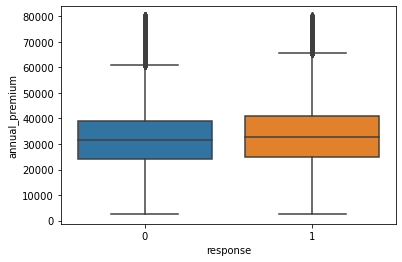

In [27]:
#annual_premium
aux = df3[df3['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

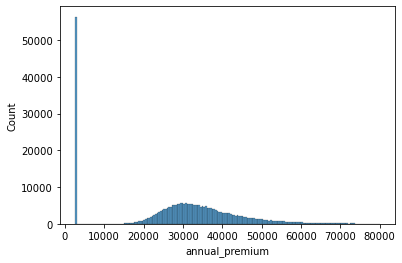

In [28]:
auxp0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(auxp0)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

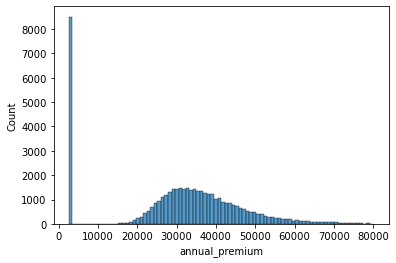

In [29]:
auxp1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(auxp1)

In [30]:
#policy_sales_channel

<AxesSubplot:xlabel='response', ylabel='vintage'>

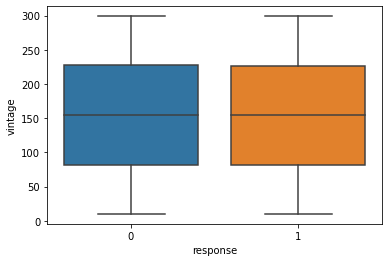

In [31]:
#vintage
#aux = df2[df2['annual_premium'] < 80000]
sns.boxplot(x='response', y='vintage', data=df3)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

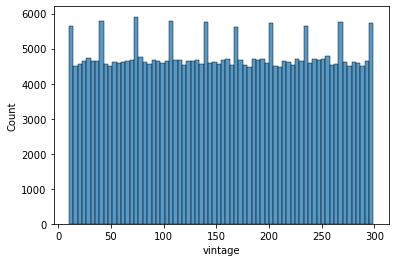

In [32]:
auxv0 = df3.loc[df3['response'] == 0, 'vintage']
sns.histplot(auxv0)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

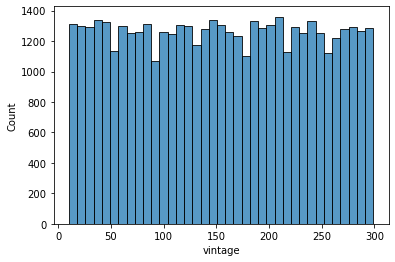

In [33]:
auxv1 = df3.loc[df2['response'] == 1, 'vintage']
sns.histplot(auxv1)

In [34]:
#response

- Hipóteses:

    - Pessoas mais jovens tem menor propensão a ter um seguro de carros
    - Mulheres tem maior propensão a ter seguro de carro
    - Pessoas com habilitação tem maior propensão a ter seguro de carro
    - Pessoas que ja possuem seguro de saude tem maiores chances de adquirir o seguro de carro
    - Pessoas que possuem carros com age < 1 tem maiores chances a adquirirem seguro de carro
    - Pessoas com vintage maior, possuem maiores chances de adquirirem seguro de carro
    - Pessoas que ja tiveram carros danificados no passado, tem maior aceitação de um seguro de carro

#### Pessoas mais jovens tem menor propensão a ter um seguro de carros

In [35]:
#sns.violinplot(data=df3, x="age", y="response")

#### Mulheres tem maior propensão a ter seguro de carro

<AxesSubplot:xlabel='gender', ylabel='response'>

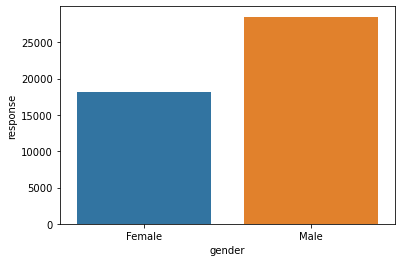

In [36]:
#df2.loc[df2['response'] == 1]

gender_response = df3[['gender', 'response']].loc[df3['response'] == 1].groupby('gender').count().reset_index()
sns.barplot(x='gender', y='response', data=gender_response)

#### Pessoas com habilitação tem maior propensão a ter seguro de carro

<AxesSubplot:xlabel='driving_license', ylabel='response'>

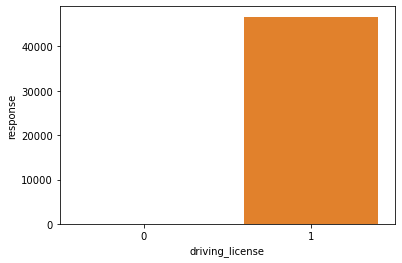

In [37]:
#df2.head()
driving_response = df3[['driving_license', 'response']].loc[df3['response'] == 1].groupby('driving_license').count().reset_index()
sns.barplot(x='driving_license', y='response', data=driving_response)

#### Pessoas que ja possuem seguro de saude tem maiores chances de adquirir o seguro de carro

<AxesSubplot:xlabel='previously_insured', ylabel='response'>

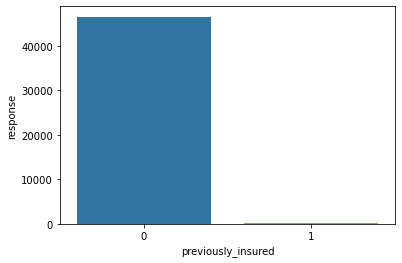

In [38]:
insured_response = df3[['previously_insured', 'response']].loc[df3['response'] == 1].groupby('previously_insured').count().reset_index()
sns.barplot(x='previously_insured', y='response', data=insured_response)

#### Pessoas que possuem carros com age < 1 tem maiores chances a adquirirem seguro de carro

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

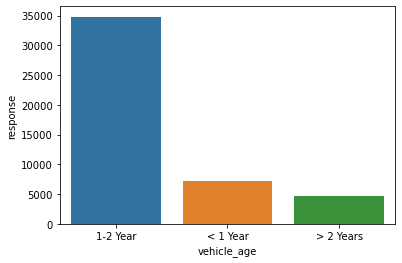

In [39]:
vehicle = df3[['vehicle_age', 'response']].loc[df3['response'] == 1].groupby('vehicle_age').count().reset_index()
sns.barplot(x='vehicle_age', y='response', data=vehicle)

#### Pessoas com vintage maior, possuem maiores chances de adquirirem seguro de carro

In [40]:
#sns.violinplot(data=df3, x="vintage", y="response")

#### Pessoas que ja tiveram carros danificados no passado, tem maior aceitação de um seguro de carro

<AxesSubplot:xlabel='vehicle_damage', ylabel='response'>

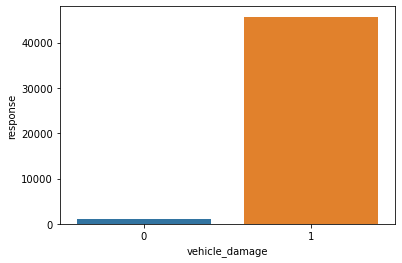

In [41]:
damage = df3[['vehicle_damage', 'response']].loc[df3['response'] == 1].groupby('vehicle_damage').count().reset_index()
sns.barplot(x='vehicle_damage', y='response', data=damage)

# 4.0 Data Preparation

In [646]:
df4 = df3.copy()

In [647]:
df_not_test, df_test = ms.train_test_split(df4, test_size=0.10, random_state=10)

df_validation, df_train = ms.train_test_split(df_not_test, test_size=0.78, random_state=10)

In [648]:
print(
f''' 
A partir do DataSet Inicial:
{round(( df_train.shape[0]/df4.shape[0])*100,0)} % é para treino
{round(( df_validation.shape[0]/df4.shape[0])*100,0)} % é para validação
{round(( df_test.shape[0]/df4.shape[0])*100,0)} % é para teste
'''
)

 
A partir do DataSet Inicial:
70.0 % é para treino
20.0 % é para validação
10.0 % é para teste



In [649]:
#df_train
y_train = df_train['response']
X_train = df_train.drop('response', axis=1)
#df_validation
y_validation = df_validation['response']
X_validation = df_validation.drop('response', axis=1)

#df_test
y_test = df_test['response']
X_test = df_test.drop('response', axis=1)




In [650]:
#X = df3.drop('response', axis=1)
#y = df3['response'].copy()
#
#x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.20)
#
##aux_validation = x_validation.copy()
##aux_validation['response'] = y_validation
#df4 = pd.concat([x_train,y_train],axis=1)

In [651]:
#x_validation

## 4.1 Standartization

In [652]:
#df4.head()

In [653]:
ss =  StandardScaler()

# annual_premium

X_train['annual_premium'] = ss.fit_transform( X_train[['annual_premium']].values )
pickle.dump(ss, open('../parameter/scaler_annual_premium.pkl', 'wb'))

## 4.2 Reescalling

In [654]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# Age (Por não se parecer com uma normal)
X_train['age'] = mms_age.fit_transform(X_train[['age']].values)
pickle.dump(mms_age, open('../parameter/age_reescaling.pkl', 'wb')  )

# vintage
X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']].values)
pickle.dump(mms_vintage, open('../parameter/vintage_reescaling.pkl', 'wb')  )

## 4.3 Encoder

In [655]:
# gender
list_gender = {'Male':1,'Female':0}
X_train['gender'] = X_train['gender'].map(list_gender)



# region_code
fe_region_code = X_train.groupby('region_code').size()/len(X_train)
X_train.loc[:,'region_code'] = X_train['region_code'].map(fe_region_code)
pickle.dump(fe_region_code, open('../parameter/encoder_region_coder.pkl', 'wb'))

## vehicle_age
X_train = pd.get_dummies(X_train, prefix='vehicle_age',columns=['vehicle_age'])

## policy_sales_channel
fe_policy_sales_channel = X_train.groupby('policy_sales_channel').size()/len(X_train)
X_train.loc[:,'policy_sales_channel'] = X_train['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../parameter/encoder_sales_channel.pkl', 'wb'))

In [656]:
X_train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
33417,266739,0,0.123077,1,0.006971,0,1,-0.382824,0.193833,0.197232,1,0,0
200971,80300,1,0.092308,1,0.019545,1,0,0.979091,0.354064,0.567474,0,1,0
210661,157868,1,0.569231,1,0.024127,1,0,0.094799,0.193833,0.505190,1,0,0
304782,149354,1,0.430769,1,0.278943,0,1,0.790034,0.209084,0.186851,1,0,0
72193,195038,1,0.261538,1,0.012241,0,1,-1.617542,0.209084,0.404844,1,0,0


## 4.4 Validation Preparation


In [657]:
#gender
list_gender = {'Male':1,'Female':0}
X_validation['gender'] = X_validation['gender'].map(list_gender)

#X_validation.loc[:,'gender'] = X_validation.loc[:,'gender'].map(target_encoder_gender)

# region_code
testando = pickle.load( open( '../parameter/encoder_region_coder.pkl', 'rb') )
X_validation.loc[:,'region_code'] = X_validation['region_code'].map(testando)


#X_validation.loc[:,'region_code'] = X_validation.loc[:,'region_code'].map(target_encode_region_code)

#vehicle_age
X_validation = pd.get_dummies(X_validation, prefix='vehicle_age',columns=['vehicle_age'])

#X_validation = pd.get_dummies(X_validation, prefix='vehicle_age', columns=['vehicle_age'])

#policy_sales_chanel
X_validation.loc[:,'policy_sales_channel'] = X_validation['policy_sales_channel'].map(fe_policy_sales_channel)

#X_validation.loc[:,'policy_sales_channel'] = X_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# age
X_validation.loc[:,'age'] = mms_age.transform(X_validation[['age']].values)

# vintage
X_validation.loc[:,'vintage'] = mms_vintage.transform(X_validation[['vintage']].values)

#annual_premium
X_validation.loc[:,'annual_premium'] = ss.transform(X_validation[['annual_premium']].values)

# fill na
X_validation = X_validation.fillna(0)


## 4.5 Test Preparation


In [658]:
#gender
list_gender = {'Male':1,'Female':0}
X_test['gender'] = X_test['gender'].map(list_gender)

#X_validation.loc[:,'gender'] = X_validation.loc[:,'gender'].map(target_encoder_gender)

# region_code
testando = pickle.load( open( '../parameter/encoder_region_coder.pkl', 'rb') )
X_test.loc[:,'region_code'] = X_test['region_code'].map(testando)


#X_validation.loc[:,'region_code'] = X_validation.loc[:,'region_code'].map(target_encode_region_code)

#vehicle_age
X_test = pd.get_dummies(X_test, prefix='vehicle_age',columns=['vehicle_age'])

#X_validation = pd.get_dummies(X_validation, prefix='vehicle_age', columns=['vehicle_age'])

#policy_sales_chanel
X_test.loc[:,'policy_sales_channel'] = X_test['policy_sales_channel'].map(fe_policy_sales_channel)

#X_validation.loc[:,'policy_sales_channel'] = X_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# age
X_test.loc[:,'age'] = mms_age.transform(X_test[['age']].values)

# vintage
X_test.loc[:,'vintage'] = mms_vintage.transform(X_test[['vintage']].values)

#annual_premium
X_test.loc[:,'annual_premium'] = ss.transform(X_test[['annual_premium']].values)

# fill na
X_test = X_test.fillna(0)


# 5.0 Feature Selection

## 5.1 Feature Importance

In [106]:
X_train

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
33417,266739,0,0.123077,1,0.006971,0,1,-0.382824,0.193833,0.197232,1,0,0
200971,80300,1,0.092308,1,0.019545,1,0,0.979091,0.354064,0.567474,0,1,0
210661,157868,1,0.569231,1,0.024127,1,0,0.094799,0.193833,0.505190,1,0,0
304782,149354,1,0.430769,1,0.278943,0,1,0.790034,0.209084,0.186851,1,0,0
72193,195038,1,0.261538,1,0.012241,0,1,-1.617542,0.209084,0.404844,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360948,220376,1,0.584615,1,0.051974,0,1,0.102966,0.017590,0.719723,1,0,0
109279,110404,1,0.600000,1,0.024127,1,0,-0.746978,0.209084,0.041522,1,0,0
343771,81304,0,0.076923,1,0.014589,1,0,-0.509672,0.354064,0.107266,0,1,0
176024,263303,0,0.661538,1,0.278943,1,0,0.192976,0.025966,0.733564,1,0,0


In [107]:
forest = en.ExtraTreesClassifier(n_estimators=100, random_state=0,n_jobs=-1)

# data_preparation
x_train_n = X_train.drop('id', axis=1)
y_train_n = y_train.values
forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_jobs=-1, random_state=0)

In [108]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]


print("importance rank")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature':i, 'importance':j}, index=[0] )
    df = pd.concat([df,aux], axis=0)

print(df.sort_values('importance', ascending=False))

importance rank
                 feature  importance
0                vintage    0.272830
0         annual_premium    0.241685
0                    age    0.172603
0            region_code    0.097602
0         vehicle_damage    0.070371
0   policy_sales_channel    0.061241
0     previously_insured    0.053859
0   vehicle_age_< 1 Year    0.016537
0   vehicle_age_1-2 Year    0.006043
0                 gender    0.004878
0  vehicle_age_> 2 Years    0.001861
0        driving_license    0.000490


# 6.0 Machine Learning

In [251]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code','vehicle_damage','policy_sales_channel', 'previously_insured']

# train
#X_train = X_train[cols_selected]
X_train_model = X_train[cols_selected].fillna(0).values
y_train_model = y_train.fillna(0).values

# validation
#X_validation = X_validation[cols_selected]
X_validation_model = X_validation[cols_selected].fillna(0).values
y_validation_model = y_validation.fillna(0).values




#x_train = df4[cols_selected]
#x_val = x_validation[cols_selected]
#y_val = y_validation.copy()

## 6.1 Knn

In [253]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=10 )

# model training
knn_model.fit(X_train_model,y_train_model)

# model prediction - Poder de GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(X_validation_model)

## 6.2 Logistic Regression

In [117]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(X_train_model,y_train_model)

# model predict
yhat_lr = lr_model.predict_proba(X_validation_model)

## 6.3 Random Forest

In [120]:
# model definition
model_rf = en.RandomForestClassifier(n_estimators = 100, random_state=42)
# model training
model_rf.fit(X_train_model,y_train_model)
# model predict
yhat_rf = model_rf.predict_proba(X_validation_model)

## 6.4 Extra Trees

In [122]:
# model definition
model_et = en.ExtraTreesClassifier( n_estimators= 100, random_state=42, n_jobs=-1 )

# model training
model_et.fit( X_train_model, y_train_model )

# model predict
yhat_et = model_et.predict_proba(X_validation_model)

# 7.0 Model Performance

In [346]:
from matplotlib.gridspec import GridSpec

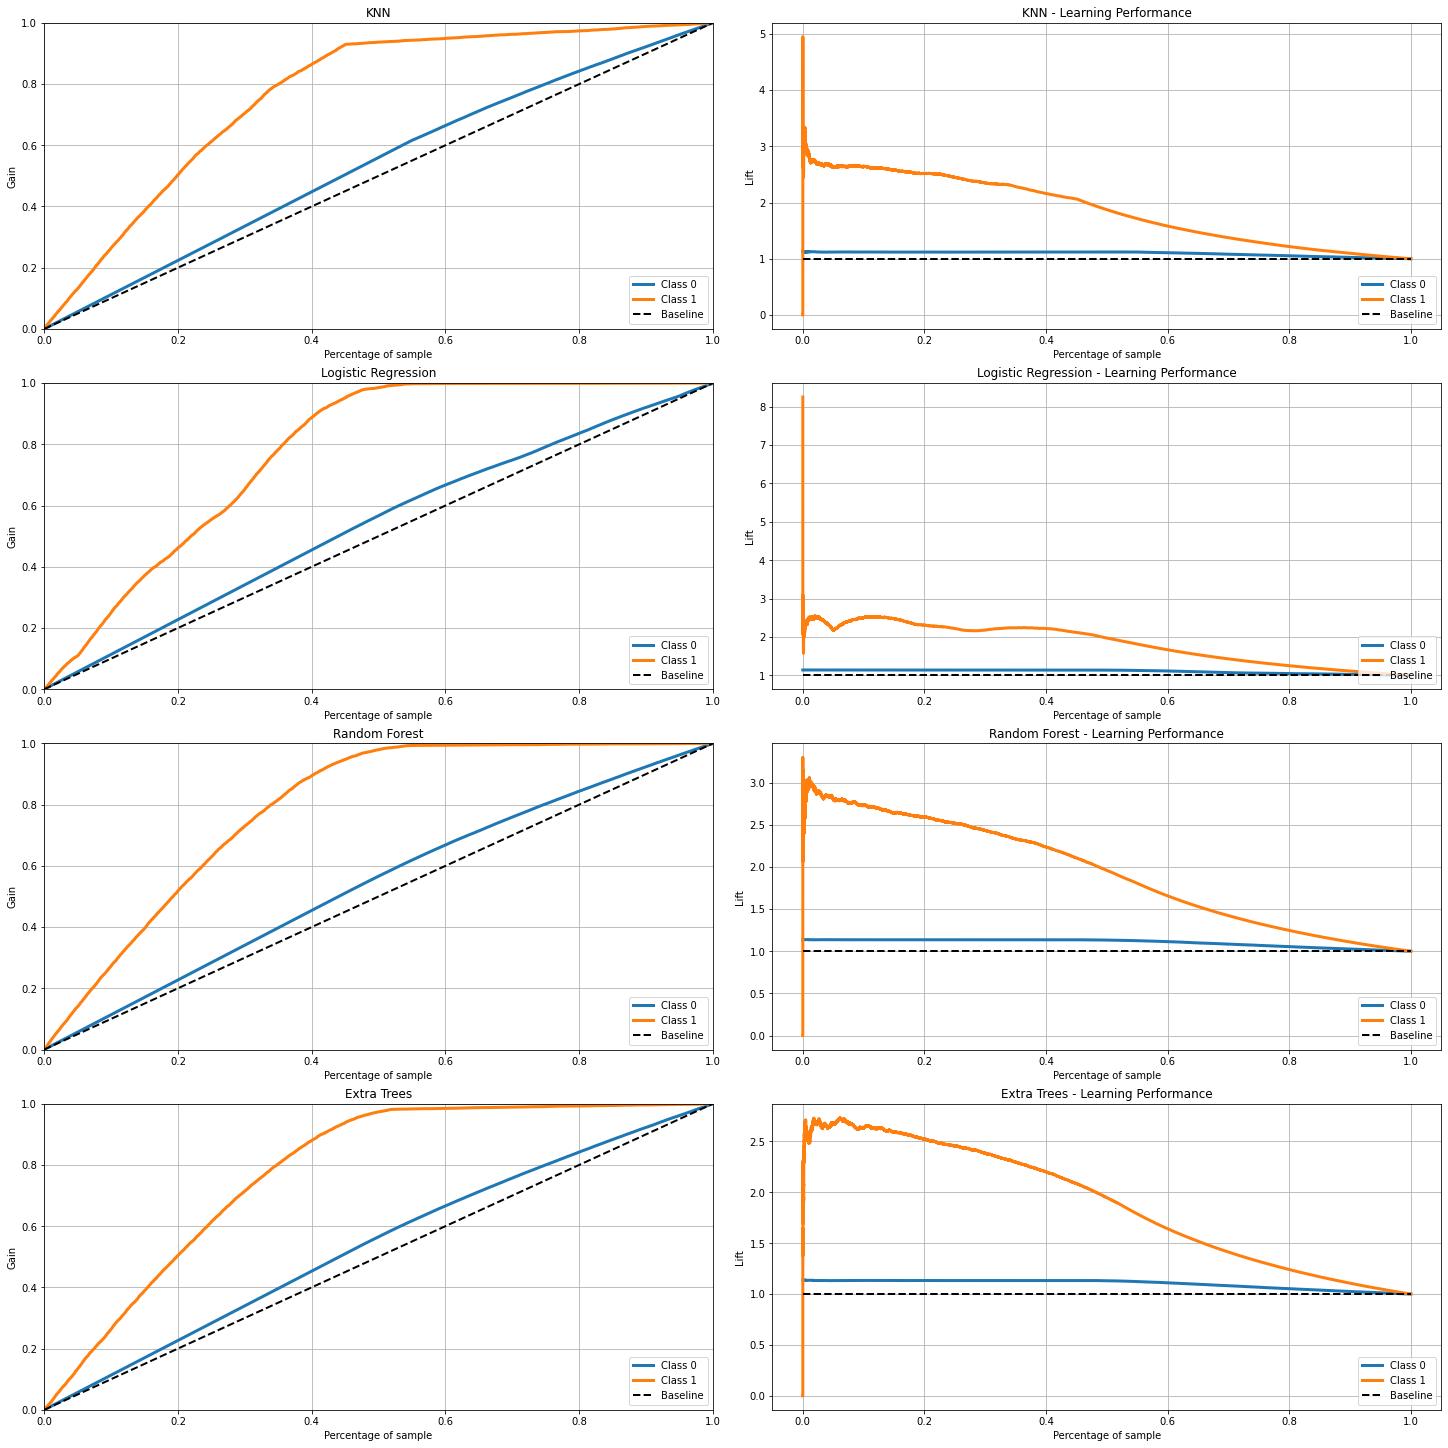

In [615]:
fig = plt.figure(figsize = (20,20), constrained_layout = True)

# create a grid for plotting
specs = GridSpec( ncols = 2, nrows = 4, figure = fig)

ax1 = fig.add_subplot( specs[0,0] )
ax2 = fig.add_subplot( specs[0,1] )

ax3 = fig.add_subplot( specs[1,0] )
ax4 = fig.add_subplot( specs[1,1] )

ax5 = fig.add_subplot( specs[2,0] )
ax6 = fig.add_subplot( specs[2,1] )

ax7 = fig.add_subplot( specs[3,0] )
ax8 = fig.add_subplot( specs[3,1] )



skplt.metrics.plot_cumulative_gain(y_validation_model,yhat_knn, title='KNN', ax=ax1)
skplt.metrics.plot_lift_curve( y_validation_model, yhat_knn, title = 'KNN - Learning Performance', ax = ax2 );

skplt.metrics.plot_cumulative_gain(y_validation_model,yhat_lr, title='Logistic Regression', ax=ax3)
skplt.metrics.plot_lift_curve( y_validation_model, yhat_lr, title = 'Logistic Regression - Learning Performance', ax = ax4 );

skplt.metrics.plot_cumulative_gain(y_validation_model,yhat_rf, title='Random Forest', ax=ax5 )
skplt.metrics.plot_lift_curve( y_validation_model, yhat_rf, title = 'Random Forest - Learning Performance', ax = ax6 );

skplt.metrics.plot_cumulative_gain(y_validation_model,yhat_et,title='Extra Trees', ax=ax7)
skplt.metrics.plot_lift_curve( y_validation_model, yhat_et, title = 'Extra Trees - Learning Performance', ax = ax8 );




In [617]:
list_proba = [yhat_knn, yhat_lr, yhat_rf,yhat_et]
list_alg = ['KNN', 'Linear Regression', 'Random Forest', 'Extra Trees']

df_precision = pd.DataFrame()
df_recall = pd.DataFrame()
df_precision['Model'] = list_alg
df_recall['Model'] = list_alg

a, b = check_performance(list_proba, X_validation, y_validation,20000) 
df_precision['precision_at_20000'], df_recall['recall_at_20000'] = check_performance(list_proba, X_validation, y_validation,20000)
df_precision['precision_at_40000'], df_recall['recall_at_40000'] = check_performance(list_proba, X_validation, y_validation,40000)


In [618]:
#teste = pd.concat([df_precision,df_recall], axis=1)
df_analysis = df_precision.merge(df_recall, how='inner', on='Model')
df_analysis = df_analysis.sort_values( ['recall_at_20000', 'recall_at_40000'], 
                                    ascending = False )
df_analysis

,Model,precision_at_20000,precision_at_40000,recall_at_20000,recall_at_40000
2,Random Forest,0.302735,0.226169,0.661893,0.988959
3,Extra Trees,0.295535,0.224519,0.646152,0.981745
0,KNN,0.294835,0.214570,0.644622,0.938238
1,Linear Regression,0.263587,0.227369,0.576301,0.994206


#### Dado o problema de negócio, escolheremos a Random Forest para aplicar o modelo em Produção!!

# 8.0 HYPERPARAMETER FINE TUNING

In [584]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

MAX_EVAL = 5

In [585]:
df_params_performance = pd.DataFrame()
df_precision = pd.DataFrame()
df_recall = pd.DataFrame()
parameters_list = []
prec_20000 = pd.DataFrame()
rec_20000 = pd.DataFrame()

prec_40000 = pd.DataFrame()
rec_40000 = pd.DataFrame()
for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: rd.sample( v, 1 )[0] for k, v in random_grid.items() }
    parameters_list.append(str(hp))
    print(hp)
    model_rf_tun = en.RandomForestClassifier(n_estimators=hp['n_estimators'],
                                                max_features=hp['max_features'],
                                                max_depth=hp['max_depth'],
                                                min_samples_split=hp['min_samples_split'],
                                                min_samples_leaf=hp['min_samples_leaf'],
                                                bootstrap=hp['bootstrap'], random_state=42 )
    
    model_rf_tun.fit(X_train_model,y_train_model)
    # model predict
    yhat_rf_tun = model_rf_tun.predict_proba(X_validation_model)
    #print(yhat_rf_tun[:,1].tolist())
    df_params_performance = pd.DataFrame(parameters_list, columns=['parameters'])
    
    lista_proba = [yhat_rf_tun]
    
    prec_20000   = prec_20000.append(check_performance(lista_proba, X_validation, y_validation,20000)[0])
    rec_20000    = rec_20000.append(check_performance(lista_proba, X_validation, y_validation,20000)[1])
    
    prec_40000   = prec_40000.append(check_performance(lista_proba, X_validation, y_validation,40000)[0])
    rec_40000    = rec_40000.append(check_performance(lista_proba, X_validation, y_validation,40000)[1])
    
    prec_20000 = prec_20000.reset_index(drop=True)
    rec_20000  = rec_20000.reset_index(drop=True)
    
    prec_40000 = prec_40000.reset_index(drop=True)
    rec_40000  = rec_40000.reset_index(drop=True)
    
    
    #df_precision['precision_at_20000'], df_recall['recall_at_20000'] = check_performance1(yhat_rf_tun, X_validation, y_validation,20000)
    #df_precision['precision_at_40000'], df_recall['recall_at_40000'] = check_performance1(yhat_rf_tun, X_validation, y_validation,40000)

df_params_performance = pd.merge(df_params_performance, prec_20000, left_index=True, right_index=True)
df_params_performance = pd.merge(df_params_performance, rec_20000, left_index=True, right_index=True)

df_params_performance = pd.merge(df_params_performance, prec_40000, left_index=True, right_index=True)
df_params_performance = pd.merge(df_params_performance, rec_40000, left_index=True, right_index=True)

df_params_performance.columns = ['parameters','precision_at_20000', 'recall_at_20000','precision_at_40000', 'recall_at_40000']
    
    
import warnings
warnings.filterwarnings("ignore")

{'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 90, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': False}
{'n_estimators': 100, 'max_features': 'auto', 'max_depth': 110, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False}
{'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 70, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False}
{'n_estimators': 700, 'max_features': 'sqrt', 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False}
{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False}


In [587]:
df_params_performance.sort_values( ['recall_at_20000', 'recall_at_40000'], 
                                    ascending = False )

,parameters,precision_at_20000,recall_at_20000,precision_at_40000,recall_at_40000
4,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.327134,0.715238,0.227744,0.995846
2,"{'n_estimators': 1000, 'max_features': 'sqrt',...",0.310084,0.677962,0.227169,0.993332
0,"{'n_estimators': 400, 'max_features': 'sqrt', ...",0.309685,0.677088,0.227094,0.993004
1,"{'n_estimators': 100, 'max_features': 'auto', ...",0.308635,0.674792,0.227269,0.993769
3,"{'n_estimators': 700, 'max_features': 'sqrt', ...",0.303085,0.662659,0.227044,0.992785


# Avaliação de Performance e Interpretação

## Performance de Aprendizado

In [588]:
melhores_parametros = {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10, 
                       'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False}

forest_tunned = en.RandomForestClassifier(n_estimators=melhores_parametros['n_estimators'],
                                                max_features=melhores_parametros['max_features'],
                                                max_depth=melhores_parametros['max_depth'],
                                                min_samples_split=melhores_parametros['min_samples_split'],
                                                min_samples_leaf=melhores_parametros['min_samples_leaf'],
                                                bootstrap=melhores_parametros['bootstrap'], random_state=42 )

# model training
forest_tunned.fit( X_train_model, y_train_model )

#predict
yhat_tunned = forest_tunned.predict_proba(X_validation_model)

Recall at 20000: 0.6446217752514211
Recall at 40000: 0.9382378662002624
Precision at 20000: 0.29483525823708817
Precision at 40000: 0.214569635759106


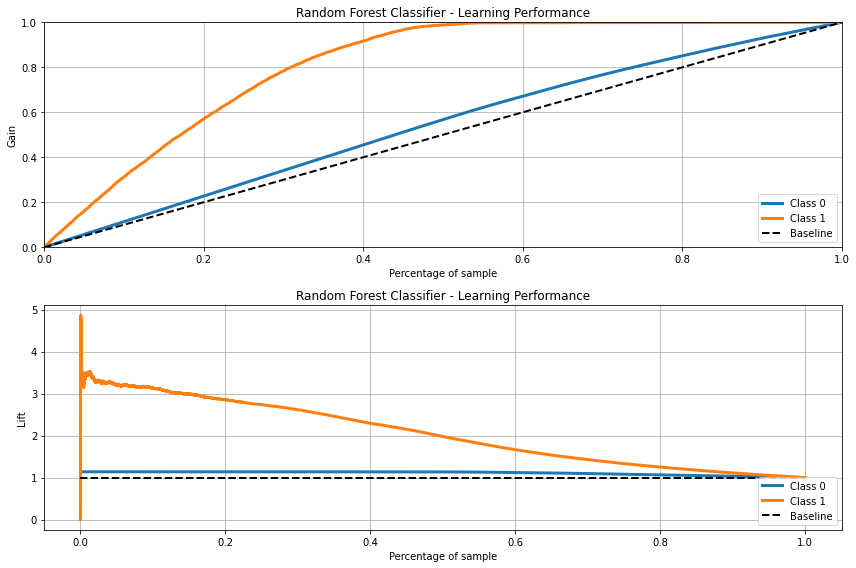

In [614]:
# avaliação
list_prob = [yhat_tunned]

print('Recall at 20000: {}'.format(check_performance(list_proba, X_validation, y_validation,20000)[1][0][0]))
print('Recall at 40000: {}'.format(check_performance(list_proba, X_validation, y_validation,40000)[1][0][0]))

print('Precision at 20000: {}'.format(check_performance(list_proba, X_validation, y_validation,20000)[0][0][0] ))
print('Precision at 40000: {}'.format(check_performance(list_proba, X_validation, y_validation,40000)[0][0][0] ))
 

# prepare figure
fig = plt.figure( figsize = (12,8), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 211 )
ax2 = fig.add_subplot( 212 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_model, yhat_tunned, 
                                    title = 'Random Forest Classifier - Learning Performance', ax = ax1 )

# plot lift curve
skplt.metrics.plot_lift_curve( y_validation_model, yhat_tunned, 
                               title = 'Random Forest Classifier - Learning Performance', ax = ax2 );

In [620]:
# concatenate X_train with X_validation to train final model
X_train_total = np.concatenate( (X_train_model, X_validation_model), axis = 0)

# concatenate Y_train with Y_validation to train final model
y_train_total = np.concatenate( (y_train_model, y_validation_model), axis = 0)

# train final model
forest_tunned.fit(X_train_total,y_train_total)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [622]:
# # Save the lgbm trained model
with open( '../model/model_health_insurance.pkl', 'wb' ) as file:
    pickle.dump( forest_tunned, file )

## Generalization Performance

- Nesse tópico, utilizaremos o DataFrame que separamos la no começo da preparação de dados (X_test). Desse modo conseguiremos ver como o modelo performa simulando um ambiente de produção.

In [632]:
health_insurance = pickle.load(open('../model/model_health_insurance.pkl', 'rb'))
#X_test = X_test[ cols_selected ]


X_test_model = X_test[ cols_selected ].fillna(0).values

y_test_model = y_test.fillna(0).values

yhat_model_health = health_insurance.predict_proba(X_test_model)

In [637]:
# calculate equivalent k (as explained above)
equivalent_k = int( (20000 / df_production.shape[0]) * df_test.shape[0] )
equivalent_k

5999

In [645]:
X_test

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
80516,0.141869,0.199522,0.076923,0.016641,0,0.354064,1
296329,0.598616,0.847782,0.046154,0.278943,0,0.354064,1
300975,0.418685,-0.006912,0.000000,0.089019,0,0.056911,1
316528,0.626298,-0.219079,0.046154,0.032134,0,0.354064,1
48123,0.377163,-1.617542,0.600000,0.006881,0,0.001080,1
...,...,...,...,...,...,...,...
309760,0.667820,-0.472892,0.292308,0.014693,1,0.209084,0
267455,0.058824,0.706395,0.646154,0.278943,0,0.004803,0
370199,0.342561,-0.080067,0.369231,0.089019,1,0.193833,0
339619,0.529412,0.387941,0.846154,0.089019,1,0.193833,1


Recall at 6000: 0.47210942509083137
Recall at 12000: 0.8093609745672152
Precision at 6000: 0.3681053157807032
Precision at 12000: 0.31555703691359055


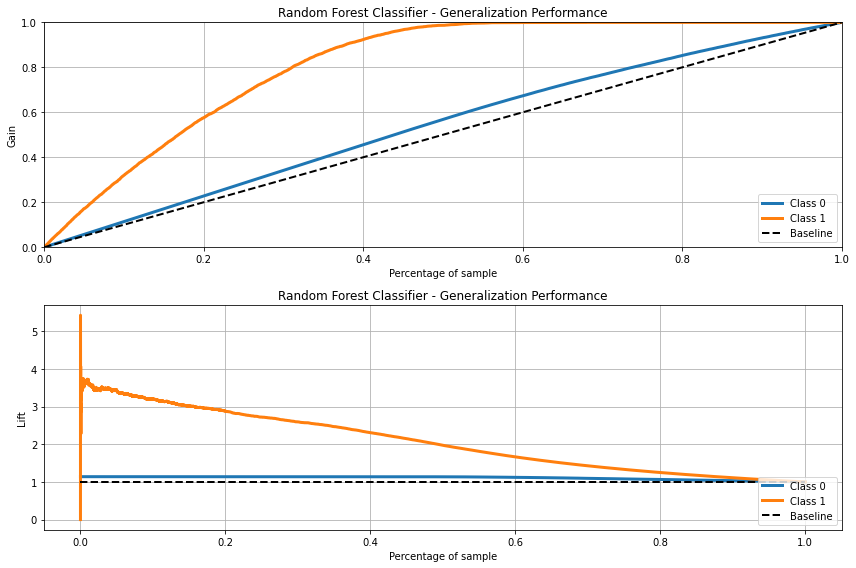

In [661]:
list_prob = [yhat_model_health]

print('Recall at 6000: {}'.format(check_performance(list_prob, X_test, y_test_model,6000)[1][0][0]))
print('Recall at 12000: {}'.format(check_performance(list_prob, X_test, y_test_model,12000)[1][0][0]))

print('Precision at 6000: {}'.format(check_performance(list_prob, X_test, y_test_model,6000)[0][0][0] ))
print('Precision at 12000: {}'.format(check_performance(list_prob, X_test, y_test_model,12000)[0][0][0] ))

#prepare figure
fig = plt.figure( figsize = (12,8), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 211 )
ax2 = fig.add_subplot( 212 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health, 
                                    title = 'Random Forest Classifier - Generalization Performance', ax = ax1 )

# plot lift curve
skplt.metrics.plot_lift_curve( y_test_model, yhat_model_health, 
                               title = 'Random Forest Classifier - Generalization Performance', ax = ax2 );

## Business Performance

### Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [662]:
twenty_k_percentage = ( 20000 / df_production.shape[0] )

twenty_k_percentage

0.15743444823161756

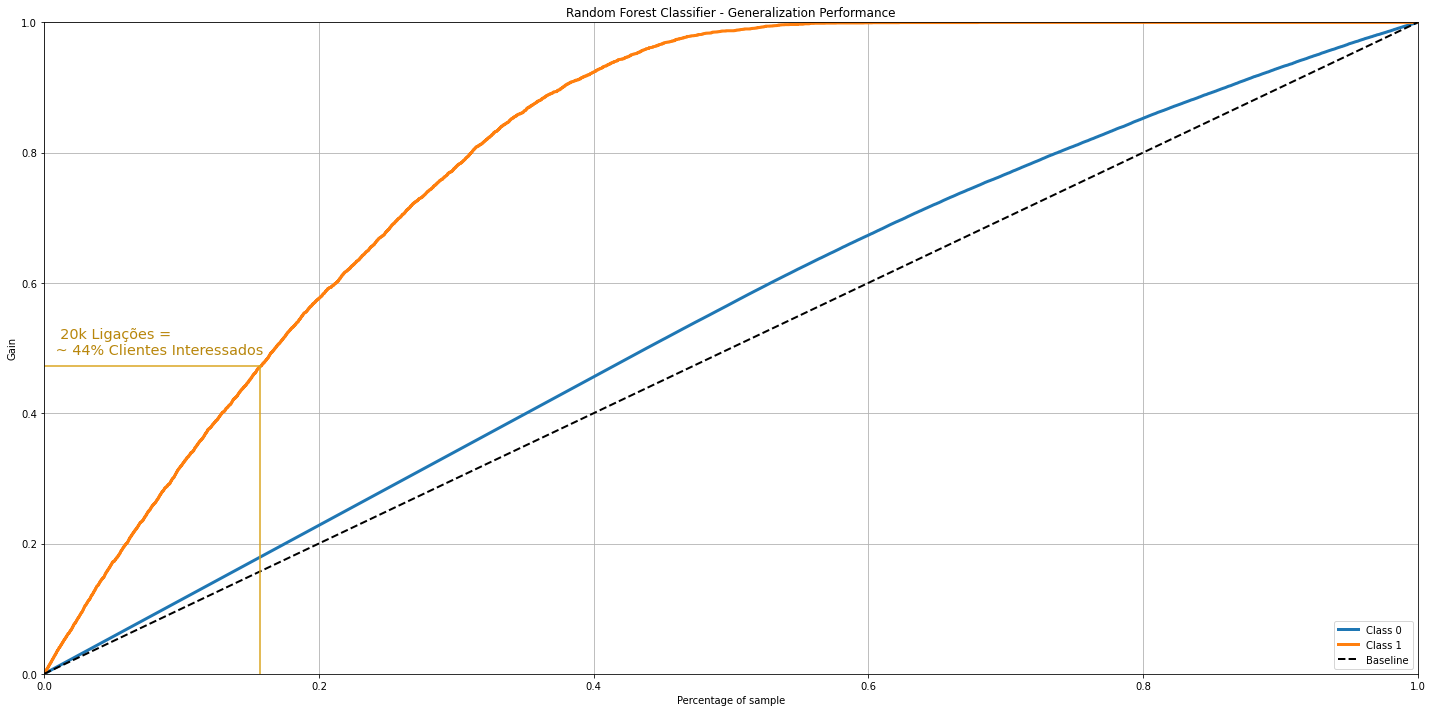

In [677]:
# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health, 
                                    title = 'Random Forest Classifier - Generalization Performance', ax = ax1 )

ax1.axvline( twenty_k_percentage, ymax = 0.472, color = 'goldenrod', label = '20k' )
ax1.axhline( 0.472 , xmax = twenty_k_percentage, color = 'goldenrod' )
plt.text( 0.005 , 0.48 + 0.01, '  20k Ligações =\n ~ 44% Clientes Interessados' , 
          color = 'darkgoldenrod', fontsize = 'x-large' );

### E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

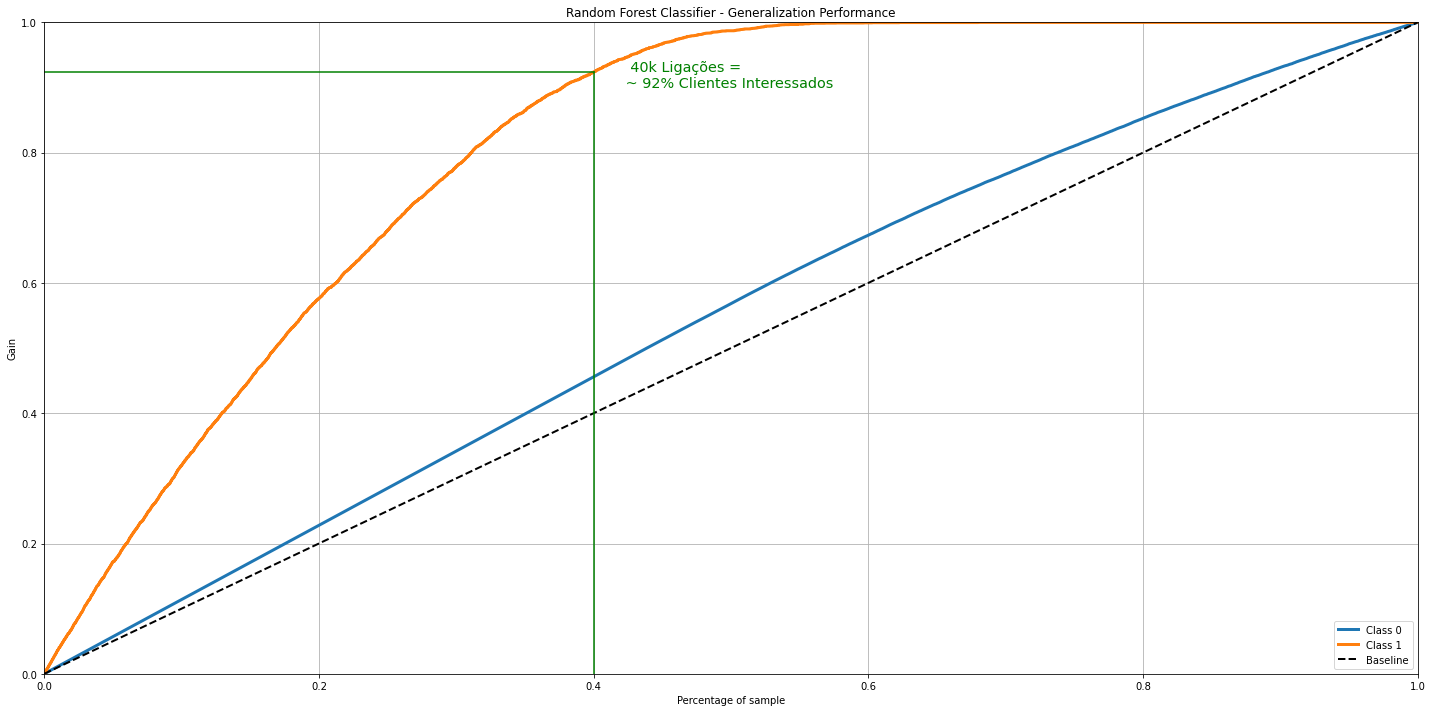

In [702]:
k_40_percentage = ( 40000 / df_production.shape[0] )

# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health, 
                                    title = 'Random Forest Classifier - Generalization Performance', ax = ax1 )

ax1.axvline( 0.4, ymax = 0.924, color = 'green', label = '40k' )
ax1.axhline( 0.924, xmax = 0.4, color = 'green', label = '40k' )

plt.text( 0.42 , 0.9, '  40k Ligações =\n ~ 92% Clientes Interessados' , 
          color = 'green', fontsize = 'x-large' );

### Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

39635.544


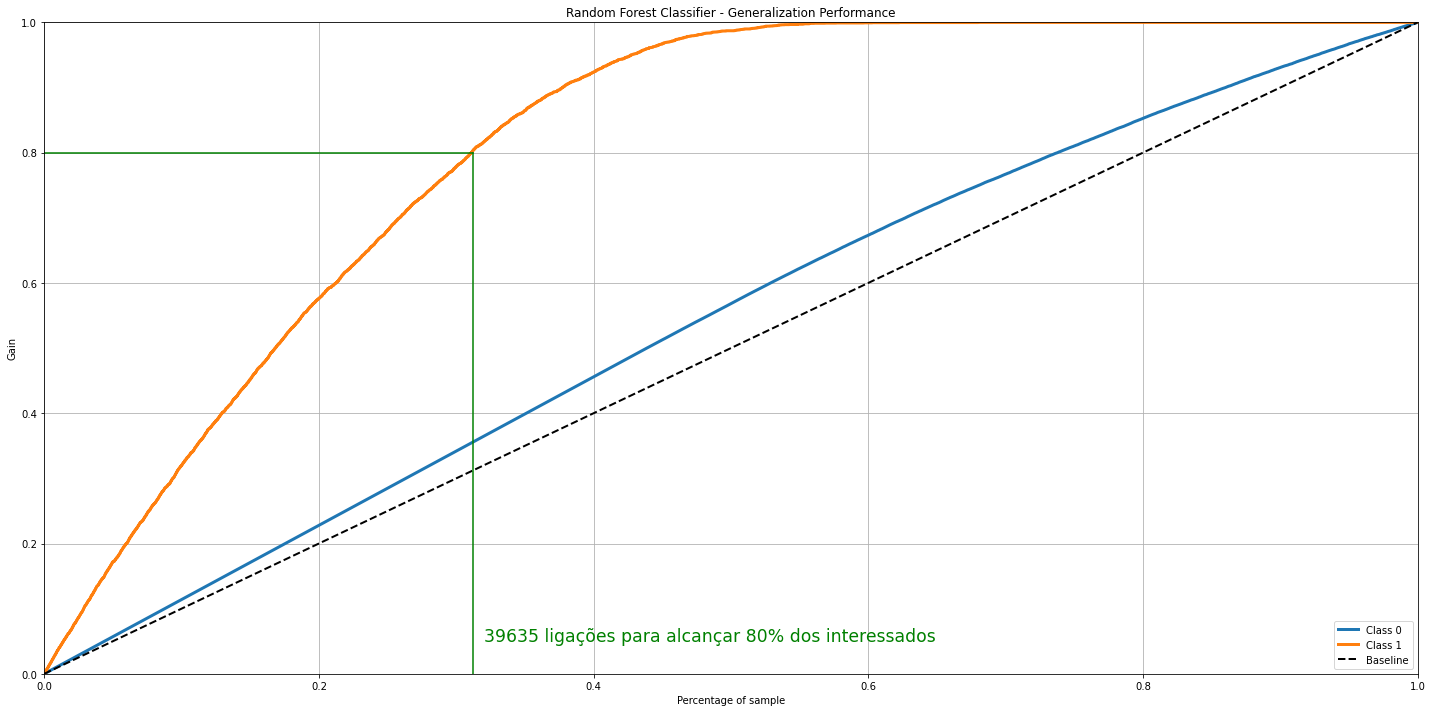

In [719]:
# prepare figure
fig = plt.figure( figsize = (20,10), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 111 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_test_model, yhat_model_health, 
                                    title = 'Random Forest Classifier - Generalization Performance', ax = ax1 )

print(0.312*df_production.shape[0])

texto = f'39635 ligações para alcançar 80% dos interessados'

ax1.axvline( 0.312, ymax = 0.8, color = 'green' )
ax1.axhline( 0.8, xmax = 0.312, color = 'green' )

plt.text( 0.32 , 0.05, texto , color = 'green', fontsize = 'xx-large' );

# 8.0 Deploy to Production

In [720]:
pickle.dump(lr_model, open('../model/model_health_insurance.pkl', 'wb'))

In [312]:
import pandas as pd
import numpy as np
import pickle


class HealthInsurance:
    def __init__( self ):
        # carregar todos os arquivos pickle de transformação de dados
        self.home_path = '/Users/thale/Documents/Projetos_DS/Comunidade DS/Health Insurance Cross-Sell/parameter/'
        self.age_scaler = pickle.load( open( self.home_path + 'age_reescaling.pkl', 'rb') )
        self.region_encoder = pickle.load( open( self.home_path + 'encoder_region_coder.pkl', 'rb') )
        self.sales_channel_encoder = pickle.load( open( self.home_path + 'encoder_sales_channel.pkl', 'rb') )
        self.annual_premium_scaler = pickle.load( open( self.home_path + 'scaler_annual_premium.pkl', 'rb') )
        self.vintage_reescaling = pickle.load( open( self.home_path + 'vintage_reescaling.pkl', 'rb') )
    
    def feature_engineering(self, df2):
        # vehicle_damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        return df2
    
    def data_preparation(self, df4):
        # standat scaler
        df4['annual_premium'] = self.annual_premium_scaler.transform( df4[['annual_premium']].values )
        
        # reescaling
        df4['age'] = self.age_scaler.transform(df4[['age']].values)

        
        df4['vintage'] = self.vintage_reescaling.transform(df4[['vintage']].values)
        
        #encoder
        
        # gender
        list_gender = {'Male':1,'Female':0}
        df4['gender'] = df4['gender'].map(list_gender)
        

        # region_code
        df4.loc[:,'region_code'] = df4['region_code'].map(self.region_encoder)
        #df4.loc[:,'region_code'] = df4['region_code'].map(target_encode_region_code)

        # policy_sales_channel
        df4.loc[:,'policy_sales_channel'] = df4['policy_sales_channel'].map(self.sales_channel_encoder)
        
        # vehicle_age
        #df4 = pd.get_dummies(df4, prefix='vehicle_age',columns=['vehicle_age'])
        
        #Feature Selection
        #df4 = df4[['vintage','annual_premium','region_code','vehicle_damage','previously_insured', 'policy_sales_channel']]
        
        df4 = df4[['vintage', 'annual_premium', 'age', 'region_code','vehicle_damage','policy_sales_channel', 'previously_insured']]
        
        
        return df4
    
    def get_prediction(slef, model, original_data, test_data):
        #return original_data, test_data
        pred = model.predict_proba(test_data)
        ##
        original_data['score'] = pred[:, 1].tolist()
        #return orinal_data
        return original_data.to_json(orient='records', date_format='iso')
        

## 8.1 API Handler

In [314]:
import pickle
import pandas as pd
import numpy as np
from flask             import Flask, request, Response
#from healthinsurance.HealthInsurance import HealthInsurance

path = '/Users/thale/Documents/Projetos_DS/Comunidade DS/Health Insurance Cross-Sell/'
model = pickle.load(open(path+'model/model_health_insurance.pkl', 'rb'))

# initialize API
#app = Flask( __name__ )

#@app.route( '/predict', methods=['POST'] )

def PredictCross():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        #test_raw1 = df_api_test.drop('id',axis=1)

        pipeline = HealthInsurance()

        dfa = pipeline.feature_engineering(test_raw)

        dfb = pipeline.data_preparation(dfa)

        df_response = pipeline.get_prediction(model, test_raw, dfb)


        return df_response
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )
    

# 9.0 API Tester

In [721]:
df_production.columns = ['id','gender','age','driving_license','region_code','previously_insured','vehicle_age','vehicle_damage','annual_premium','policy_sales_channel','vintage']
df_api_test = df_production.copy()

In [722]:
# select a random sample to check api
df_api_test = df_api_test.sample(10)
#df_api_test.dtypes

In [723]:
data = json.dumps( df_api_test.drop('id',axis=1).to_dict( orient='records' ) )

In [724]:
#data

In [725]:
#url = 'http://127.0.0.1:5000/predict'
url = 'https://health-model-insurance.herokuapp.com/predict'

header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [726]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [727]:
d1

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
0,1,0.569231,1,0.278943,0,1-2 Year,1,0.298684,0.004803,0.252595,0.314266
1,1,0.584615,1,0.278943,0,1-2 Year,1,-1.617542,0.001540,0.539792,0.311435
2,0,0.600000,1,0.278943,0,1-2 Year,1,-1.617542,0.001275,0.031142,0.308915
3,0,0.430769,1,0.278943,0,1-2 Year,1,-1.617542,0.209084,0.795848,0.277772
4,0,0.292308,1,0.034997,0,1-2 Year,1,0.735124,0.025966,0.262976,0.253093
5,0,0.615385,1,0.032134,0,1-2 Year,1,0.311195,0.209084,0.868512,0.220796
6,1,0.476923,1,0.034997,0,1-2 Year,0,-1.617542,0.209084,0.401384,0.033394
7,1,0.646154,1,0.278943,1,1-2 Year,0,-0.105147,0.003271,0.110727,0.001034
8,1,0.000000,1,0.020206,1,< 1 Year,0,-1.617542,0.056911,0.695502,0.000744
9,0,0.061538,1,0.020206,1,< 1 Year,0,0.833186,0.354064,0.276817,0.000583
